# 0.0 Imports

In [93]:
import re
import requests
import torch
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer,AutoModelForSequenceClassification
from bs4 import BeautifulSoup
from tqdm import tqdm  
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax

from sklearn.metrics import precision_score

## Data Mining

In [ ]:
pages = list(range(10, 1600, 10))
reviews = []


for page in pages:
    # Construct the URL with the 'start' parameter
    url = f'https://www.yelp.com/biz/fogo-de-chão-brazilian-steakhouse-san-diego-3?start={page}'

    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # getting comments
    regex = re.compile('.*comment.*')
    results = soup.find_all('p', {'class': regex})

    # getting stars
    regex_stars = re.compile('.*stars.*')
    ratings = soup.find_all('div', {'class': regex_stars})
    
    # Iterate elements to pair
    for result, rating in zip(results, ratings):
        rating_text = rating.get_text(strip=True)
        
        if re.match(r'^\d+(\.\d+)?$', rating_text):
            number = '0'

        else:
            aria_label = rating['aria-label']
            number = (aria_label.split()[0])

        # append
        reviews.append((result.text, number))
    

# 'reviews' now contains reviews from multiple pages
print(len(reviews), 'reviews scraped in total.')

In [ ]:
# load reviews into dataframe and score it
df = pd.DataFrame(reviews, columns=['review', 'vote'])

for i in range(len(df)):
    if df.loc[i, 'vote'] == '(no':
        df.loc[i, 'vote'] = '0'
df['vote'] = df['vote'].astype(np.float64)

### 0.2 Load Data

In [109]:
df = pd.read_csv('../data/raw/fogo_reviews.csv').reset_index()
df = df.drop(['Unnamed: 0'], axis=1)

# 1.0 Data Description

## 1.1 Data Dimensions

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963 entries, 0 to 1962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  1963 non-null   object 
 1   vote    1963 non-null   float64
dtypes: float64(1), object(1)
memory usage: 30.8+ KB


## 1.2 Descriptive Statistics

### Numerical

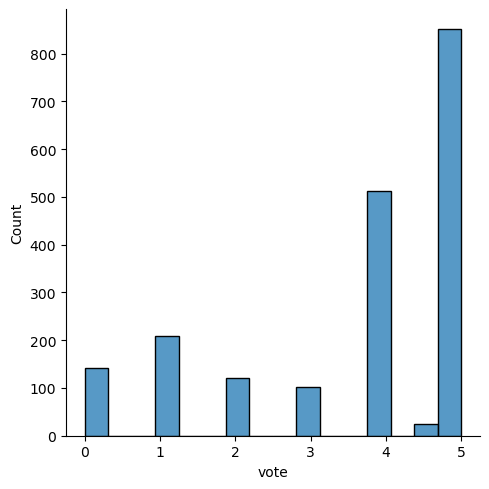

In [21]:
sns.displot(data=df, x='vote');

# 2.0 Machine Learnign Modeling

### 2.1 VADER Model

In [22]:
# define the model
sia = SentimentIntensityAnalyzer()

In [28]:
# run polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review']
    my_id = row['index']
    res[my_id] = sia.polarity_scores(text)

  0%|          | 0/1963 [00:00<?, ?it/s]

In [89]:
# merge predictions to the original df
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index()
vaders = vaders.merge(df, how='left')
vaders = vaders[['index', 'neg', 'neu', 'pos', 'compound', 'vote', 'review']]

In [90]:
vaders.head()

,index,neg,neu,pos,compound,vote,review
0,0,0.000,0.789,0.211,0.9775,4.0,A truly mediocre meal. We went for Saturday b...
1,1,0.023,0.697,0.280,0.9530,0.0,Serving exceptional meals is what we strive fo...
2,2,0.025,0.604,0.370,0.9924,4.0,We found an amazing deal on instagram for a sp...
3,3,0.032,0.924,0.044,0.3086,3.0,So we came downtown today to see a Filipino ar...
4,4,0.022,0.798,0.180,0.9741,5.0,I had always heard of Fogo Dr Chão so I decide...


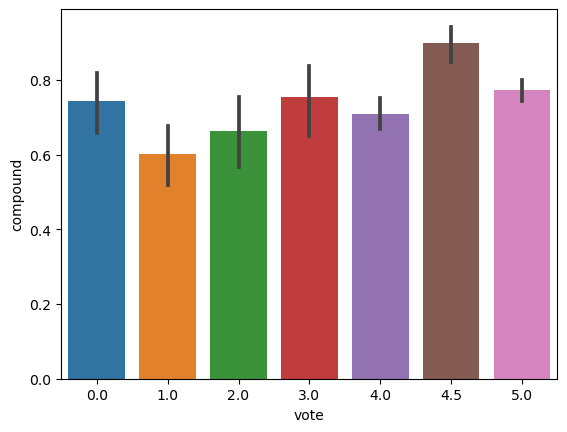

In [92]:
sns.barplot(data=vaders, x='vote', y='compound');

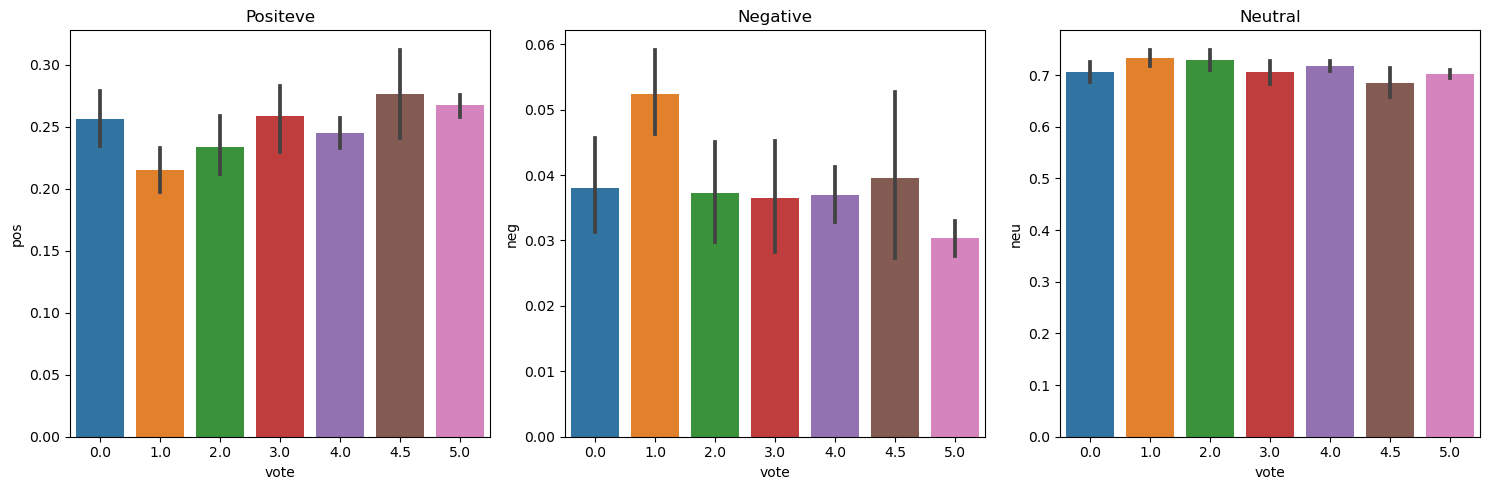

In [95]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=vaders, x='vote', y='pos', ax=axs[0]);
sns.barplot(data=vaders, x='vote', y='neg', ax=axs[1]);
sns.barplot(data=vaders, x='vote', y='neu', ax=axs[2]);
axs[0].set_title('Positeve')
axs[1].set_title('Negative')
axs[2].set_title('Neutral')
plt.tight_layout()

### Transformers Pipeline

In [142]:
# define model
sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [143]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review']
        my_id = row['index']
        
        res[my_id] = sent_pipeline(text)   
    
    except RuntimeError:
        print(f'Broke for id {my_id}')

  0%|          | 0/1963 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (644 > 512). Running this sequence through the model will result in indexing errors


Broke for id 20
Broke for id 43
Broke for id 63
Broke for id 77
Broke for id 146
Broke for id 147
Broke for id 184
Broke for id 285
Broke for id 364
Broke for id 392
Broke for id 393
Broke for id 394
Broke for id 439
Broke for id 467
Broke for id 475
Broke for id 561
Broke for id 598
Broke for id 634
Broke for id 655
Broke for id 672
Broke for id 783
Broke for id 926
Broke for id 951
Broke for id 957
Broke for id 958
Broke for id 960
Broke for id 987
Broke for id 1047
Broke for id 1211
Broke for id 1331
Broke for id 1380
Broke for id 1488
Broke for id 1508
Broke for id 1523
Broke for id 1547
Broke for id 1552
Broke for id 1557
Broke for id 1634
Broke for id 1662
Broke for id 1704
Broke for id 1719
Broke for id 1746
Broke for id 1815
Broke for id 1819
Broke for id 1927
Broke for id 1954


In [145]:
data_list = [item[0] for item in res.values()]
df_res = pd.DataFrame(data_list).reset_index()

In [146]:
df_trans = df.merge(df_res, how='left')

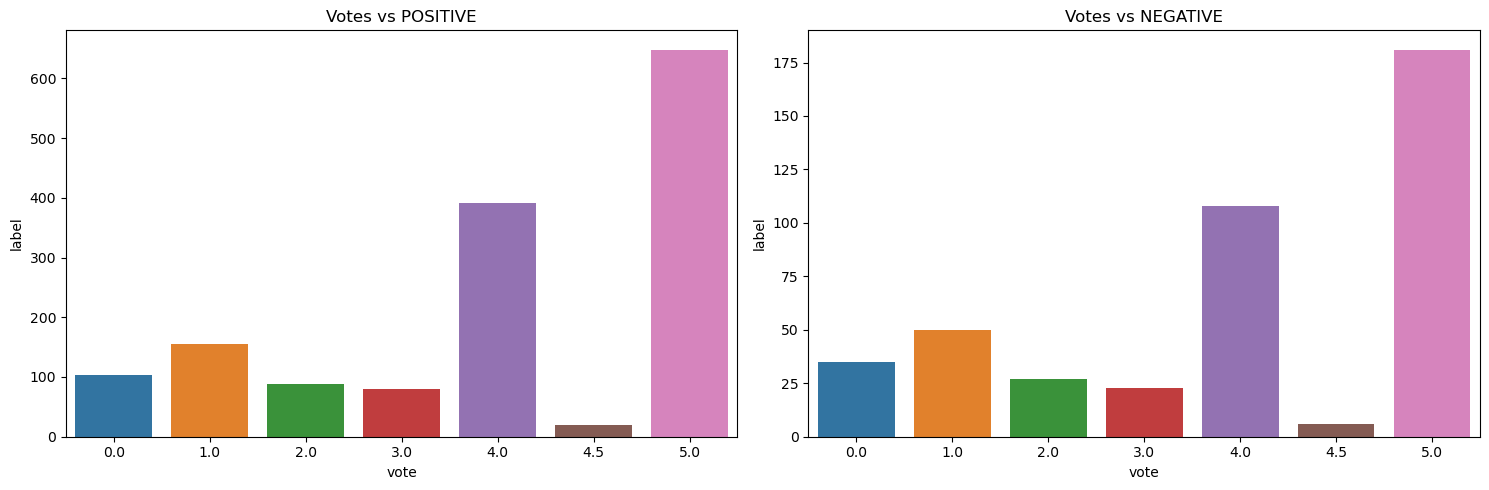

In [147]:
pos = df_trans[df_trans['label'] == 'POSITIVE' ]
neg = df_trans[df_trans['label'] == 'NEGATIVE']

df_pos = pos[['vote', 'label']].groupby('vote').count().reset_index()
df_neg = neg[['vote', 'label']].groupby('vote').count().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.barplot(data=df_pos, x='vote', y='label', ax=axs[0]);
sns.barplot(data=df_neg, x='vote', y='label', ax=axs[1]);
axs[0].set_title('Votes vs POSITIVE')
axs[1].set_title('Votes vs NEGATIVE')
plt.tight_layout()

In [137]:
len(neg), len(pos)

(430, 1487)

### Roberta

In [156]:
# Define the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [157]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [158]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review']
        myid = row['index']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1963 [00:00<?, ?it/s]

Broke for id 20
Broke for id 43
Broke for id 77
Broke for id 146
Broke for id 147
Broke for id 184
Broke for id 285


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index()
results_df = results_df.merge(df, how='left')